# TPHLCT 3階の導関数を相殺する

In [15]:
import numpy as np
import scipy.misc
from scipy.fftpack import dct, idct
import sys
from PIL import Image
import matplotlib
import matplotlib.pyplot as plt
import random
from tqdm._tqdm_notebook import tqdm_notebook
from scipy.fftpack import dct, idct
import seaborn as sns
from skimage.metrics import structural_similarity as ssim
import pandas as pd

%matplotlib inline


class ImageLoader:
    def __init__(self, FILE_PATH):
        self.img = np.array(Image.open(FILE_PATH))
        # 行数
        self.row_blocks_count = self.img.shape[0] // 8
        # 列数
        self.col_blocks_count = self.img.shape[1] // 8

    def get_points(self, POINT):
        Row = random.randint(0, len(self.img) - POINT - 1)
        Col = random.randint(0, len(self.img) - 1)
        return self.img[Row : Row + POINT, Col]

    def get_block(self, col, row):
        return self.img[col * 8 : (col + 1) * 8, row * 8 : (row + 1) * 8]


# plt.rcParams['font.family'] ='sans-serif'#使用するフォント
# plt.rcParams["font.sans-serif"] = "Source Han Sans"
plt.rcParams["font.family"] = "Source Han Sans JP"  # 使用するフォント
plt.rcParams["xtick.direction"] = "in"  # x軸の目盛線が内向き('in')か外向き('out')か双方向か('inout')
plt.rcParams["ytick.direction"] = "in"  # y軸の目盛線が内向き('in')か外向き('out')か双方向か('inout')
plt.rcParams["xtick.major.width"] = 1.0  # x軸主目盛り線の線幅
plt.rcParams["ytick.major.width"] = 1.0  # y軸主目盛り線の線幅
plt.rcParams["font.size"] = 12  # フォントの大きさ
plt.rcParams["axes.linewidth"] = 1.0  # 軸の線幅edge linewidth。囲みの太さ
matplotlib.font_manager._rebuild()

MONO_DIR_PATH = "../../Mono/"
AIRPLANE = ImageLoader(MONO_DIR_PATH + "airplane512.bmp")
BARBARA = ImageLoader(MONO_DIR_PATH + "barbara512.bmp")
BOAT = ImageLoader(MONO_DIR_PATH + "boat512.bmp")
GOLDHILL = ImageLoader(MONO_DIR_PATH + "goldhill512.bmp")
LENNA = ImageLoader(MONO_DIR_PATH + "lenna512.bmp")
MANDRILL = ImageLoader(MONO_DIR_PATH + "mandrill512.bmp")
MILKDROP = ImageLoader(MONO_DIR_PATH + "milkdrop512.bmp")
SAILBOAT = ImageLoader(MONO_DIR_PATH + "sailboat512.bmp")
TEST02 = ImageLoader(MONO_DIR_PATH + "test02.bmp")
TEST19 = ImageLoader(MONO_DIR_PATH + "test19.bmp")
N8RGB = ImageLoader(MONO_DIR_PATH + "N8RGB.bmp")


N = 16

# DCT

## 基底関数

$$
\phi_k[i] = \begin{cases}
\cfrac{1}{\sqrt{N}}  \quad \quad \quad (k=0) \\
\sqrt{\cfrac{2}{N}} \cos \left({\cfrac{\pi}{2N}(2i+1)k}\right) \quad  (k=1,2,...,N-1) 
\end{cases}
$$

In [16]:
class DCT:
    def __init__(self, N):
        self.N = N  # データ数
        # 1次元DCTの基底ベクトルの生成
        self.phi_1d = np.array([self.phi(i) for i in range(self.N)])
        # 2次元DCTの基底ベクトルの格納
        self.phi_2d = np.zeros((N, N))

    def phi(self, k):
        """ 離散コサイン変換(DCT)の基底関数 """
        # DCT-II
        if k == 0:
            return np.ones(self.N) / np.sqrt(self.N)
        else:
            return np.sqrt(2.0 / self.N) * np.cos(
                (k * np.pi / (2 * self.N)) * (np.arange(self.N) * 2 + 1)
            )

    def dct(self, data):
        """ 1次元離散コサイン変換を行う """
        return self.phi_1d.dot(data)

    def idct(self, c):
        """ 1次元離散コサイン逆変換を行う """
        return np.sum(self.phi_1d.T * c, axis=1)

    def get_dct2_phi(self, y, x):
        """ 2次元離散コサイン変換の基底を返す """
        phi_x, phi_y = np.meshgrid(self.phi_1d[x], self.phi_1d[y])
        return phi_x * phi_y

    def get_dct2(self, y, x, data):
        """ i,jの2次元DCT係数を返す """
        phi_2d_phi = np.zeros((self.N, self.N))
        phi_2d_phi = self.get_dct2_phi(y, x)
        return np.sum(np.sum(phi_2d_phi * data))

    def dct2(self, data):
        """ 2次元離散コサイン変換を行う """
        for y in range(self.N):
            for x in range(self.N):
                self.phi_2d[y, x] = self.get_dct2(y, x, data)

        return self.phi_2d

    def idct2(self, c):
        """ 2次元離散コサイン逆変換を行う """
        idct2_data = np.zeros((self.N, self.N))
        phi_2d_phi = np.zeros((self.N, self.N))
        for y in range(self.N):
            for x in range(self.N):
                phi_2d_phi = self.get_dct2_phi(y, x)
                idct2_data += c[y,x] * phi_2d_phi

        return idct2_data

# MSDS

In [17]:
def msds(N,arr):
    w_e = 0
    e_e = 0
    n_e = 0
    s_e = 0
    nw_e = 0
    ne_e = 0
    sw_e = 0
    se_e = 0
    for row in range(arr.shape[0] // N):
        for col in range(arr.shape[1] // N):
            f_block = arr[row * N : (row + 1) * N, col * N : (col + 1) * N]
            # w
            if col == 0:
                w_block = np.fliplr(f_block)
            else:
                w_block = arr[row * N : (row + 1) * N, (col - 1) * N : col * N]
            # e
            if col == arr.shape[1] // N - 1:
                e_block = np.fliplr(f_block)
            else:
                e_block = arr[row * N : (row + 1) * N, (col + 1) * N : (col + 2) * N]
            # n
            if row == 0:
                n_block = np.flipud(f_block)
            else:
                n_block = arr[(row - 1) * N : row * N, col * N : (col + 1) * N]
            # s
            if row == arr.shape[0] // N - 1:
                s_block = np.flipud(f_block)
            else:
                s_block = arr[(row + 1) * N : (row + 2) * N, col * N : (col + 1) * N]

            w_d1 = f_block[:, 0] - w_block[:, N-1]
            e_d1 = f_block[:, N-1] - e_block[:, 0]
            n_d1 = f_block[0, :] - n_block[N-1, :]
            s_d1 = f_block[N-1, :] - s_block[0, :]

            w_d2 = (w_block[:, N-1] - w_block[:, N-2] + f_block[:, 1] - f_block[:, 0]) / 2
            e_d2 = (e_block[:, 1] - e_block[:, 0] + f_block[:, N-1] - f_block[:, N-2]) / 2
            n_d2 = (n_block[N-1, :] - n_block[N-2, :] + f_block[1, :] - f_block[0, :]) / 2
            s_d2 = (s_block[1, :] - s_block[0, :] + f_block[N-1, :] - f_block[N-2, :]) / 2

            w_e += np.sum((w_d1 - w_d2) ** 2 )
            e_e += np.sum((e_d1 - e_d2) ** 2 )
            n_e += np.sum((n_d1 - n_d2) ** 2)
            s_e += np.sum((s_d1 - s_d2) ** 2)

            # nw
            if row == 0 or col == 0:
                nw_block = np.flipud(np.fliplr(f_block))
            else:
                nw_block = arr[(row - 1) * N : row * N, (col - 1) * N : col * N]
            # ne
            if row == 0 or col == arr.shape[1] // N - 1:
                ne_block = np.flipud(np.fliplr(f_block))
            else:
                ne_block = arr[(row-1) * N : row * N, (col + 1) * N : (col + 2) * N]
            # sw
            if row == arr.shape[0] // N -1 or col == 0:
                sw_block = np.flipud(np.fliplr(f_block))
            else:
                sw_block = arr[row * N : (row+1) * N, (col-1) * N : col * N]
            # se
            if  row == arr.shape[0]//N-1 or col == arr.shape[0] // N -1:
                se_block = np.flipud(np.fliplr(f_block))
            else:
                se_block = arr[(row + 1) * N : (row + 2) * N, (col+1) * N : (col + 2) * N]

            nw_g1 = f_block[0, 0] - nw_block[N-1, N-1]
            ne_g1 = f_block[0, N-1] - ne_block[N-1, 0]
            sw_g1 = f_block[N-1, 0] - sw_block[0, N-1]
            se_g1 = f_block[N-1, N-1] - se_block[0, 0]

            nw_g2 = (nw_block[N-1,N-1] - nw_block[N-2,N-2] + f_block[1,1] - f_block[0,0])/2
            ne_g2 = (ne_block[N-1,0] - ne_block[N-2,1] + f_block[1,N-2] - f_block[0,N-1])/2
            sw_g2 = (sw_block[0,N-1] - nw_block[1,N-2] + f_block[N-2,1] - f_block[N-1,0])/2
            se_g2 = (nw_block[0,0] - nw_block[1,1] + f_block[N-2,N-2] - f_block[N-1,N-1])/2

            nw_e += (nw_g1 - nw_g2) ** 2 
            ne_e += (ne_g1 - ne_g2) ** 2 
            sw_e += (sw_g1 - sw_g2) ** 2 
            se_e += (se_g1 - se_g2) ** 2 

    MSDSt = (w_e + e_e + n_e + s_e + nw_e + ne_e + sw_e + se_e)/ ((arr.shape[0]/N)**2)
    MSDS1 = (w_e + e_e + n_e + s_e)/ ((arr.shape[0]/N)**2)
    MSDS2 = (nw_e + ne_e + sw_e + se_e)/ ((arr.shape[0]/N)**2)
    return MSDSt, MSDS1, MSDS2

# 係数の計算

$\alpha_k, \beta_k$を計算する。  
1階導関数を相殺するような予測関数は 
$$u(x)=-\frac{f_x(0)}{2}(1-x^2)+\frac{f_x(1)}{2}x^2$$
で与えられる。  

そのとき、   
$$\alpha_k = -\sqrt{\frac{2}{N}}\sum_{\ell=0}^{N-1}\frac{(1-x_\ell)^2}{2}\cos(\pi k x_\ell)$$  
$$\beta_k = \sqrt{\frac{2}{N}}\sum_{\ell=0}^{N-1}\frac{x_\ell^2}{2}\cos(\pi k x_\ell)$$  

$a_k, b_k, c_k, d_k$を計算する。  
3階導関数を相殺するような予測関数は 
$$
\begin{align}
u(x) & =( -\frac{1}{2}f_x(0) + \frac{1}{12}f^{(3)}_x(0) )(1-x^2)\\
     & -\frac{1}{24}f^{(3)}_x(0)(1-x)^4\\
     & +( \frac{1}{2}f_x(1)-\frac{1}{12}f^{(3)}_x(1) )x^2\\
     & + \frac{1}{24}f^{(3)}_x(1)x^4
\end{align}
$$
で与えられる。  

そのとき、   
$$a_k = -\sqrt{\frac{2}{N}}\sum_{\ell=0}^{N-1}\frac{(1-x_\ell)^2}{2}\cos(\pi k x_\ell)$$  

$$b_k= \sqrt{\frac{2}{N}}\sum_{\ell=0}^{N-1}( \frac{1}{24}-\frac{x_\ell^2}{6}+\frac{x_\ell^3}{6}-\frac{x_\ell^4}{24} )\cos(\pi k x_\ell)$$  

$$c_k = \sqrt{\frac{2}{N}}\sum_{\ell=0}^{N-1}\frac{x_\ell^2}{2}\cos(\pi k x_\ell)$$

$$d_k = \sqrt{\frac{2}{N}}\sum_{\ell=0}^{N-1}( -\frac{x_\ell^2}{12}+\frac{x_\ell^4}{24} )\cos(\pi k x_\ell)$$  

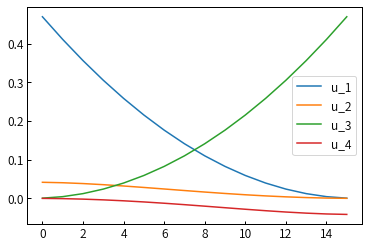

In [18]:
sampling_x = (0.5 + np.arange(N)) / N
u_1 = (1 - sampling_x) ** 2 / 2
u_2 = 1 / 24 - sampling_x ** 2 / 6 + sampling_x ** 3 / 6 - sampling_x ** 4 / 24
u_3 = sampling_x ** 2 / 2
u_4 = -sampling_x ** 2 / 12 + sampling_x ** 4 / 24
plt.plot(u_1, label="u_1")
plt.plot(u_2, label="u_2")
plt.plot(u_3, label="u_3")
plt.plot(u_4, label="u_4")
plt.legend()

In [19]:
ak = - scipy.fftpack.dct(u_1,norm="ortho")
ak

array([-6.66015625e-01, -5.72235345e-01, -1.42356572e-01, -6.27352552e-02,
       -3.48506640e-02, -2.19246012e-02, -1.48813893e-02, -1.06106807e-02,
       -7.81250000e-03, -5.86493057e-03, -4.43936892e-03, -3.34812741e-03,
       -2.47676043e-03, -1.75117449e-03, -1.12037363e-03, -5.46725910e-04])

In [20]:
bk = scipy.fftpack.dct(u_2,norm="ortho")
bk

array([7.77777036e-02, 5.80730594e-02, 3.62946361e-03, 7.16837860e-04,
       2.26725367e-04, 9.27830699e-05, 4.46610568e-05, 2.40199717e-05,
       1.39872233e-05, 8.63042295e-06, 5.54832686e-06, 3.65886073e-06,
       2.43057806e-06, 1.58247439e-06, 9.55052288e-07, 4.50105928e-07])

In [21]:
ck = scipy.fftpack.dct(u_3,norm="ortho")
ck

array([ 6.66015625e-01, -5.72235345e-01,  1.42356572e-01, -6.27352552e-02,
        3.48506640e-02, -2.19246012e-02,  1.48813893e-02, -1.06106807e-02,
        7.81250000e-03, -5.86493057e-03,  4.43936892e-03, -3.34812741e-03,
        2.47676043e-03, -1.75117449e-03,  1.12037363e-03, -5.46725910e-04])

In [22]:
dk = scipy.fftpack.dct(u_4,norm="ortho")
dk

array([-7.77777036e-02,  5.80730594e-02, -3.62946361e-03,  7.16837860e-04,
       -2.26725367e-04,  9.27830699e-05, -4.46610568e-05,  2.40199717e-05,
       -1.39872233e-05,  8.63042295e-06, -5.54832686e-06,  3.65886073e-06,
       -2.43057806e-06,  1.58247439e-06, -9.55052288e-07,  4.50105928e-07])

In [23]:
alpha = ak
alpha

array([-6.66015625e-01, -5.72235345e-01, -1.42356572e-01, -6.27352552e-02,
       -3.48506640e-02, -2.19246012e-02, -1.48813893e-02, -1.06106807e-02,
       -7.81250000e-03, -5.86493057e-03, -4.43936892e-03, -3.34812741e-03,
       -2.47676043e-03, -1.75117449e-03, -1.12037363e-03, -5.46725910e-04])

In [24]:
beta = ck
beta

array([ 6.66015625e-01, -5.72235345e-01,  1.42356572e-01, -6.27352552e-02,
        3.48506640e-02, -2.19246012e-02,  1.48813893e-02, -1.06106807e-02,
        7.81250000e-03, -5.86493057e-03,  4.43936892e-03, -3.34812741e-03,
        2.47676043e-03, -1.75117449e-03,  1.12037363e-03, -5.46725910e-04])

In [25]:
Ak = (2 * ak - 16 * bk) / np.sqrt(N)
Ak

array([-6.44118627e-01, -5.18409910e-01, -8.56961403e-02, -3.42349791e-02,
       -1.83322335e-02, -1.13334329e-02, -7.61933886e-03, -5.40142024e-03,
       -3.96219889e-03, -2.96698698e-03, -2.24187777e-03, -1.68869915e-03,
       -1.24810253e-03, -8.81917144e-04, -5.64007025e-04, -2.75163379e-04])

In [26]:
Bk = (2 * ck - 16 * dk) / np.sqrt(N)
Bk

array([ 6.44118627e-01, -5.18409910e-01,  8.56961403e-02, -3.42349791e-02,
        1.83322335e-02, -1.13334329e-02,  7.61933886e-03, -5.40142024e-03,
        3.96219889e-03, -2.96698698e-03,  2.24187777e-03, -1.68869915e-03,
        1.24810253e-03, -8.81917144e-04,  5.64007025e-04, -2.75163379e-04])

In [27]:
Ck = (2 * ak - 32 * bk) / np.sqrt(N)
Ck

array([-9.55229441e-01, -7.50702148e-01, -1.00213995e-01, -3.71023305e-02,
       -1.92391349e-02, -1.17045652e-02, -7.79798309e-03, -5.49750012e-03,
       -4.01814779e-03, -3.00150867e-03, -2.26407108e-03, -1.70333459e-03,
       -1.25782484e-03, -8.88247042e-04, -5.67827235e-04, -2.76963802e-04])

In [28]:
Dk = (2 * ck - 32 * dk) / np.sqrt(N)
Dk

array([ 9.55229441e-01, -7.50702148e-01,  1.00213995e-01, -3.71023305e-02,
        1.92391349e-02, -1.17045652e-02,  7.79798309e-03, -5.49750012e-03,
        4.01814779e-03, -3.00150867e-03,  2.26407108e-03, -1.70333459e-03,
        1.25782484e-03, -8.88247042e-04,  5.67827235e-04, -2.76963802e-04])

# DCTして残差を計算

$
V_k = F_k - U_k\\
V_k = F_k - A_k(F_0-F_0^L) -B_k(F_0^R-F_0)-C_k(F_1+F_1^L)-D_k(F_1^R+F_1)
$

In [29]:
IMG = N8RGB

In [30]:
Fk = np.zeros(IMG.img.shape)

## DCT 縦方向

2次元入力信号を垂直方向の一次元信号が水平方向に並列に並んでいるものとみなし、各列において8画素単位の1次元DCTを適用する

In [31]:
for row in range(IMG.img.shape[0] // 16):
    for col in range(IMG.img.shape[1]):
        eight_points = IMG.img[16 * row : 16 * (row + 1), col]
        c = scipy.fftpack.dct(eight_points,norm="ortho")
        Fk[16 * row : 16 * (row + 1), col] = c
        

## 縦方向の残差

### 3階の導関数

In [32]:
for row in range(Fk.shape[0] // 16):
    for col in range(Fk.shape[1]):
        F = Fk[16 * row : 16 * (row + 1), col]

        F_0_r = 0
        F_1_r = 0
        if row is not Fk.shape[0] // 16 - 1:
            F_0_r = Fk[16 * (row + 1), col]
            F_1_r = Fk[16 * (row + 1) + 1, col]

        F_0_l = 0
        F_1_l = 1
        if row is not 0:
            F_0_l = Fk[16 * (row - 1), col]
            F_1_l = Fk[16 * (row - 1) + 1, col]

        # 残差
        F_0 = F[0]
        F_1 = F[1]

        F = (
            F
            - Ak * (F_0 - F_0_l)
            - Bk * (F_0_r - F_0)
            - Ck * (F_1 + F_1_l)
            - Dk * (F_1_r + F_1)
        )
        # F_0, F_1は残す
        F[0] = F_0
        F[1] = F_1
        # F_0 V_1 V_2 V_3 V_4 V_5 V_6 V_7
        Fk[16 * row : 16 * (row + 1), col] = F
        

### 1階の導関数

In [33]:
for row in range(Fk.shape[0] // 16):
    for col in range(Fk.shape[1]):
        F = Fk[16 * row : 16 * (row + 1), col]

        F_0_r = 0
        if row is not Fk.shape[0] // 16 - 1:
            F_0_r = Fk[16 * (row + 1), col]

        F_0_l = 0
        if row is not 0:
            F_0_l = Fk[16 * (row - 1), col]

        # 残差
        F_0 = F[0]
        F_temp = F - alpha * (F_0_r - F_0) / np.sqrt(N) - beta * (F_0 - F_0_l) / np.sqrt(N)
        # F_0は残す
        F[1] = F_temp[1]
        # F_0 V_1 V_2 V_3 V_4 V_5 V_6 V_7
        Fk[16 * row : 16 * (row + 1), col] = F
        

## DCT 横方向

In [34]:
for row in range(Fk.shape[0]):
    for col in range(Fk.shape[1] // 16):
        eight_points = Fk[row, 16 * col : 16 * (col + 1)]
        c = scipy.fftpack.dct(eight_points,norm="ortho")
        Fk[row, 16 * col : 16 * (col + 1)] = c
        

## 横方向の残差

### 3階の導関数

In [35]:
for row in range(Fk.shape[0]):
    for col in range(Fk.shape[1] // 16):
        F = Fk[row, 16 * col : 16 * (col + 1)]

        F_0_r = 0
        F_1_r = 0
        if col is not Fk.shape[1] // 16 - 1:
            F_0_r = Fk[row, 16 * (col + 1)]
            F_1_r = Fk[row, 16 * (col + 1) + 1]

        F_0_l = 0
        F_1_l = 0
        if col is not 0:
            F_0_l = Fk[row, 16 * (col - 1)]
            F_1_l = Fk[row, 16 * (col - 1) + 1]

        # 残差
        F_0 = F[0]
        F_1 = F[1]

        F = (
            F
            - Ak * (F_0 - F_0_l)
            - Bk * (F_0_r - F_0)
            - Ck * (F_1 + F_1_l)
            - Dk * (F_1_r + F_1)
        )
        # F_0は残す
        F[0] = F_0
        F[1] = F_1
        # F_0 V_1 V_2 V_3 V_4 V_5 V_6 V_7
        Fk[row, 16 * col : 16 * (col + 1)] = F
        

### 1階の導関数

In [36]:
for row in range(Fk.shape[0]):
    for col in range(Fk.shape[1] // 16):
        F = Fk[row, 16 * col : 16 * (col + 1)]

        F_0_r = 0
        if col is not Fk.shape[1] // 16 - 1:
            F_0_r = Fk[row, 16 * (col + 1)]

        F_0_l = 0
        if col is not 0:
            F_0_l = Fk[row, 16 * (col - 1)]

        # 残差
        F_0 = F[0]
        F_temp = F - alpha * (F_0_r - F_0) / np.sqrt(N) - beta * (F_0 - F_0_l) / np.sqrt(N)
        # F_0は残す
        F[1] = F_temp[1]
        # F_0 V_1 V_2 V_3 V_4 V_5 V_6 V_7
        Fk[row, 16 * col : 16 * (col + 1)] = F
        

# 係数の確保

In [37]:
Fk_Ori = np.copy(Fk)

# 低域3成分 (0,1)(1,0)(1,1)の絶対値の和

In [24]:
low_3_value = 0
others_value = 0

In [25]:
for row in range(Fk.shape[0] // 16):
    for col in range(Fk.shape[1] // 16):
        block = Fk[row * 16 : (row + 1) * 16, col * 16 : (col + 1) * 16]
        low_3_value += np.abs(block[0, 1]) + np.abs(block[1, 0]) + np.abs(block[1, 1])
        others_value += (
            np.sum(np.sum(np.abs(block)))
            - np.abs(block[0, 0])
            - np.abs(block[0, 1])
            - np.abs(block[1, 0])
            - np.abs(block[1, 1])
        )
        

In [26]:
low_3_value

243866.7786621404

In [27]:
others_value

1662482.5355466295

# 逆変換

$
F_k = F_k + U_k\\
F_k = V_k + A_k(F_0-F_0^L) +B_k(F_0^R-F_0)+C_k(F_1+F_1^L)+D_k(F_1^R+F_1)
$

In [28]:
# recover = np.zeros(IMG.img.shape).astype("uint8")
recover = np.zeros(IMG.img.shape)

## 横方向の残差

### 1階の導関数 

In [29]:
for row in range(Fk.shape[0]):
    for col in range(Fk.shape[1] // 16):
        F = Fk[row, 16 * col : 16 * col + 16]

        F_0_r = 0
        if col is not Fk.shape[1] // 16 - 1:
            F_0_r = Fk[row, 16 * (col + 1)]

        F_0_l = 0
        if col is not 0:
            F_0_l = Fk[row, 16 * (col - 1)]

        # 残差
        F_0 = F[0]
        F_temp = F + alpha * (F_0_r - F_0) / np.sqrt(N) + beta * (F_0 - F_0_l) / np.sqrt(N)
        # F_0は残す
        F[1] = F_temp[1]
        # F_0 V_1 V_2 V_3 V_4 V_5 V_6 V_7
        Fk[row, 16 * col : 16 * col + 16] = F
        

### 3階の導関数

In [30]:
for row in range(Fk.shape[0]):
    for col in range(Fk.shape[1] // 16):
        F = Fk[row, 16 * col : 16 * (col + 1)]

        F_0_r = 0
        F_1_r = 0
        if col is not Fk.shape[1] // 16 - 1:
            F_0_r = Fk[row, 16 * (col + 1)]
            F_1_r = Fk[row, 16 * (col + 1) + 1]

        F_0_l = 0
        F_1_l = 0
        if col is not 0:
            F_0_l = Fk[row, 16 * (col - 1)]
            F_1_l = Fk[row, 16 * (col - 1) + 1]

        # 残差
        F_0 = F[0]
        F_1 = F[1]

        F = (
            F
            + Ak * (F_0 - F_0_l)
            + Bk * (F_0_r - F_0)
            + Ck * (F_1 + F_1_l)
            + Dk * (F_1_r + F_1)
        )
        # F_0は残す
        F[0] = F_0
        F[1] = F_1
        # F_0 V_1 V_2 V_3 V_4 V_5 V_6 V_7
        Fk[row, 16 * col : 16 * (col + 1)] = F
        

### IDCT 横方向

In [31]:
for row in range(Fk.shape[0]):
    for col in range(Fk.shape[1] // 16):
        F = Fk[row, 16 * col : 16 * col + 16]
        data = scipy.fftpack.idct(F,norm="ortho")
        # Fkに代入した後、縦方向に対して処理
        Fk[row, 16 * col : 16 * col + 16] = data
        # 復元画像
#         recover[row, 16 * col : 16 * col + 16] = data


## 縦方向

### 1階の導関数

In [32]:
for row in range(Fk.shape[0] // 16):
    for col in range(Fk.shape[1]):
        F = Fk[16 * row : 16 * row + 16, col]

        F_0_r = 0
        if row is not Fk.shape[0] // 16 - 1:
            F_0_r = Fk[16 * (row + 1), col]

        F_0_l = 0
        if row is not 0:
            F_0_l = Fk[16 * (row - 1), col]

        # 残差
        F_0 = F[0]
        F_temp = F + alpha * (F_0_r - F_0) / np.sqrt(N) + beta * (F_0 - F_0_l) / np.sqrt(N)
        # F_0は残す
        F[1] = F_temp[1]
        # F_0 F_1 F_2 F_3 F_4 F_5 F_6 F_7
        Fk[16 * row : 16 * row + 16, col] = F
        

### 3階の導関数

In [33]:
for row in range(Fk.shape[0] // 16):
    for col in range(Fk.shape[1]):
        F = Fk[16 * row : 16 * (row + 1), col]

        F_0_r = 0
        F_1_r = 0
        if row is not Fk.shape[0] // 16 - 1:
            F_0_r = Fk[16 * (row + 1), col]
            F_1_r = Fk[16 * (row + 1) + 1, col]

        F_0_l = 0
        F_1_l = 1
        if row is not 0:
            F_0_l = Fk[16 * (row - 1), col]
            F_1_l = Fk[16 * (row - 1) + 1, col]

        # 残差
        F_0 = F[0]
        F_1 = F[1]

        F = (
            F
            + Ak * (F_0 - F_0_l)
            + Bk * (F_0_r - F_0)
            + Ck * (F_1 + F_1_l)
            + Dk * (F_1_r + F_1)
        )
        # F_0, F_1は残す
        F[0] = F_0
        F[1] = F_1
        # F_0 V_1 V_2 V_3 V_4 V_5 V_6 V_7
        Fk[16 * row : 16 * (row + 1), col] = F
        

### 縦方向IDCT

In [34]:
for row in range(Fk.shape[0] // 16):
    for col in range(Fk.shape[1]):
        F = Fk[16 * row : 16 * (row + 1), col]
        data = scipy.fftpack.idct(F,norm="ortho")
        # 復元画像
        recover[16 * row : 16 * (row + 1), col] = data
        # FKに代入した後、横方向に対して処理
#         Fk[16 * row : 16 * (row + 1), col] = data


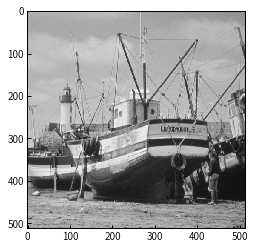

In [35]:
plt.imshow(np.round(recover), cmap="gray")

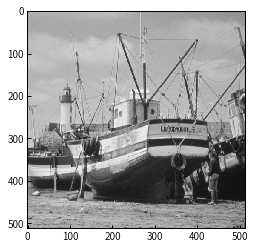

In [36]:
plt.imshow(IMG.img, cmap="gray")

In [37]:
recover[0, 0:10]

array([166., 162., 166., 166., 167., 170., 166., 169., 170., 166.])

In [38]:
IMG.img[0, 0:10]

array([166, 162, 166, 166, 167, 170, 166, 169, 170, 166], dtype=uint8)

ちゃんと復元できた

# 量子化テーブル

In [38]:
bpp = np.arange(0.2,0.8,0.05)
Q_Fk = np.zeros(Fk.shape)
for i in bpp:
    low = 0
    high = 100
    for j in range(10):
        mid = (low + high)/2
        
        Q = mid
        Q_Luminance = np.ones((16,16)) * Q
        Fk = np.copy(Fk_Ori)

        Q_Fk = np.zeros(Fk.shape)
        for row in range(IMG.img.shape[0] // 16):
            for col in range(IMG.img.shape[1] // 16):
                block = Fk[row * 16 : (row + 1) * 16, col * 16 : (col + 1) * 16]
                # 量子化
                block = np.round(block / Q_Luminance)
                # 逆量子化
                block = block * Q_Luminance
                Q_Fk[row * 16 : (row+1)*16, col * 16 : (col+1)*16] = block

        qfk = pd.Series(Q_Fk.flatten())
        pro = qfk.value_counts() / qfk.value_counts().sum()
        S = 0
        for pi in pro:
            S -= pi * np.log2(pi)

        if S < i:
            high = mid
        elif S > i:
            low = mid   
            
    Fk = np.copy(Q_Fk)
    Q_recover = np.zeros(Q_Fk.shape)
    # 横方向
    for row in range(Fk.shape[0]):
        for col in range(Fk.shape[1] // 16):
            F = Fk[row, 16 * col : 16 * col + 16]

            F_0_r = 0
            if col is not Fk.shape[1] // 16 - 1:
                F_0_r = Fk[row, 16 * (col + 1)]

            F_0_l = 0
            if col is not 0:
                F_0_l = Fk[row, 16 * (col - 1)]

            # 残差
            F_0 = F[0]
            F_temp = F + alpha * (F_0_r - F_0) / np.sqrt(N) + beta * (F_0 - F_0_l) / np.sqrt(N)
            # F_0は残す
            F[1] = F_temp[1]
            # F_0 V_1 V_2 V_3 V_4 V_5 V_6 V_7
            Fk[row, 16 * col : 16 * col + 16] = F

    for row in range(Fk.shape[0]):
        for col in range(Fk.shape[1] // 16):
            F = Fk[row, 16 * col : 16 * (col + 1)]

            F_0_r = 0
            F_1_r = 0
            if col is not Fk.shape[1] // 16 - 1:
                F_0_r = Fk[row, 16 * (col + 1)]
                F_1_r = Fk[row, 16 * (col + 1) + 1]

            F_0_l = 0
            F_1_l = 0
            if col is not 0:
                F_0_l = Fk[row, 16 * (col - 1)]
                F_1_l = Fk[row, 16 * (col - 1) + 1]

            # 残差
            F_0 = F[0]
            F_1 = F[1]

            F = (
                F
                + Ak * (F_0 - F_0_l)
                + Bk * (F_0_r - F_0)
                + Ck * (F_1 + F_1_l)
                + Dk * (F_1_r + F_1)
            )
            # F_0は残す
            F[0] = F_0
            F[1] = F_1
            # F_0 V_1 V_2 V_3 V_4 V_5 V_6 V_7
            Fk[row, 16 * col : 16 * (col + 1)] = F

    for row in range(Fk.shape[0]):
        for col in range(Fk.shape[1] // 16):
            F = Fk[row, 16 * col : 16 * col + 16]
            data = scipy.fftpack.idct(F,norm="ortho")
            # Fkに代入した後、縦方向に対して処理
            Fk[row, 16 * col : 16 * col + 16] = data
            # 復元画像
    #         recover[row, 16 * col : 16 * col + 16] = data
    for row in range(Fk.shape[0] // 16):
        for col in range(Fk.shape[1]):
            F = Fk[16 * row : 16 * row + 16, col]

            F_0_r = 0
            if row is not Fk.shape[0] // 16 - 1:
                F_0_r = Fk[16 * (row + 1), col]

            F_0_l = 0
            if row is not 0:
                F_0_l = Fk[16 * (row - 1), col]

            # 残差
            F_0 = F[0]
            F_temp = F + alpha * (F_0_r - F_0) / np.sqrt(N) + beta * (F_0 - F_0_l) / np.sqrt(N)
            # F_0は残す
            F[1] = F_temp[1]
            # F_0 F_1 F_2 F_3 F_4 F_5 F_6 F_7
            Fk[16 * row : 16 * row + 16, col] = F

    for row in range(Fk.shape[0] // 16):
        for col in range(Fk.shape[1]):
            F = Fk[16 * row : 16 * (row + 1), col]

            F_0_r = 0
            F_1_r = 0
            if row is not Fk.shape[0] // 16 - 1:
                F_0_r = Fk[16 * (row + 1), col]
                F_1_r = Fk[16 * (row + 1) + 1, col]

            F_0_l = 0
            F_1_l = 1
            if row is not 0:
                F_0_l = Fk[16 * (row - 1), col]
                F_1_l = Fk[16 * (row - 1) + 1, col]

            # 残差
            F_0 = F[0]
            F_1 = F[1]

            F = (
                F
                + Ak * (F_0 - F_0_l)
                + Bk * (F_0_r - F_0)
                + Ck * (F_1 + F_1_l)
                + Dk * (F_1_r + F_1)
            )
            # F_0, F_1は残す
            F[0] = F_0
            F[1] = F_1
            # F_0 V_1 V_2 V_3 V_4 V_5 V_6 V_7
            Fk[16 * row : 16 * (row + 1), col] = F

    for row in range(Fk.shape[0] // 16):
        for col in range(Fk.shape[1]):
            F = Fk[16 * row : 16 * (row + 1), col]
            data = scipy.fftpack.idct(F,norm="ortho")
            # 復元画像
            Q_recover[16 * row : 16 * (row + 1), col] = data
            # FKに代入した後、横方向に対して処理
    #         Fk[16 * row : 16 * (row + 1), col] = data

    Q_recover = np.round(Q_recover)

        
#     bpp = np.arange(0.2,0.8,0.05)
#     for i in bpp:
#         if np.abs(i - S) < 0.003:
    MSE = np.sum(np.sum(np.power((IMG.img - Q_recover),2)))/(Q_recover.shape[0] * Q_recover.shape[1])
    PSNR = 10 * np.log10(255 * 255 / MSE)
    MSSIM = ssim(IMG.img,Q_recover.astype(IMG.img.dtype),gaussian_weights=True,sigma=1.5,K1=0.01,K2=0.03)
    MSDSt, MSDS1, MSDS2 = msds(16,Q_recover)
    print("S=",S)
    print(Q,PSNR,MSSIM,MSDS1,MSDS2)
 

S= 0.19982214900053097
88.76953125 31.908634456021936 0.8549449362541923 11381.623046875 4487.0137939453125
S= 0.2502580341500531
65.91796875 33.51297563463924 0.8832789601355141 9669.393798828125 4302.436767578125
S= 0.2995910348312089
51.66015625 34.83140755939532 0.9030054684662525 8449.45947265625 4079.6011962890625
S= 0.35040809559238484
41.50390625 36.020585543754564 0.9183952182316215 7629.2498779296875 4066.4638061523438
S= 0.3992400630253923
34.47265625 37.04830658481857 0.930446206793239 7006.15673828125 3898.8606567382812
S= 0.45100718983754606
28.80859375 38.03048133085934 0.940612269757799 6572.2257080078125 3849.4903564453125
S= 0.5000751036470844
24.70703125 38.858196242362546 0.9486175420429843 6214.2181396484375 3789.786376953125
S= 0.5487658318598797
21.38671875 39.63335722601348 0.9548350266070991 5942.080322265625 3745.7201538085938
S= 0.599620766816595
18.65234375 40.340748858276356 0.9603086761196107 5738.7833251953125 3687.5090942382812
S= 0.6521870388078852
16.3